##### $\hspace{15pt}$ **Filename: anomalyDetectionOnHealthcareProvidersData.ipynb**
##### $\hspace{1.5pt}$ **Date Created: January 28, 2024**
##### **Date Modified: February 6, 2024**
##### $\rule{10.5in}{1pt}$
##### **Run anomaly detection algorithms on [healthcare providers data](https://www.kaggle.com/datasets/tamilsel/healthcare-providers-data) from Kaggle.**

##### **The file `healthcareProvidersData.csv` that has to be accessed is available in this [Google Drive folder](https://drive.google.com/drive/folders/1WcVbVyLLZcKcX3HIOep1fOyxGt8vQWYV?usp=sharing). Before running this notebook in Colab, either change the path in cell `7`, or create the subfolder `/Colab Notebooks/013_anomalyDetectionOnHealthcareProvidersData` in your Google drive and copy the file to the subfolder. Restart the runtime after installing the packages and before running the remaining cells of the notebook.**

##### $\rule{10.5in}{1pt}$

##### Install `combo`, `hypertools`, and `pyod`.

In [ ]:
!pip install combo -q hypertools -q pyod -q

##### Update `seaborn`.

In [ ]:
!pip install -U seaborn -q

##### Restart the runtime, and load modules and packages.

In [ ]:
from google.colab import drive
from pyod.models.abod import ABOD
from pyod.models.alad import ALAD
from pyod.models.cblof import CBLOF
from pyod.models.cd import CD
from pyod.models.copod import COPOD
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.dif import DIF
from pyod.models.ecod import ECOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.inne import INNE
from pyod.models.knn import KNN
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.models.lunar import LUNAR
from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.qmcd import QMCD
from pyod.models.sampling import Sampling
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import combo
import contextlib
import io
import hypertools as hyp
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import seaborn as sns
import time
import warnings

##### Suppress warnings.

In [ ]:
warnings.filterwarnings("ignore")

##### Set the seed to initialize the random number generator.

In [ ]:
random.seed(1)

##### Set pandas dataframes to display all the columns.

In [ ]:
pd.set_option("display.max_columns", None)

##### Set the float format of pandas dataframes.

In [ ]:
pd.options.display.float_format = "{:.2f}".format

##### Mount Google Drive to Colab.

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##### Set the path to access the file needed by this notebook.

In [ ]:
path = "gdrive/MyDrive/Colab Notebooks/013_anomalyDetectionOnHealthcareProvidersData/"

$\hspace{1in}$

##### **Data Preparation**

##### Load the dataset from Google Drive.

In [ ]:
dataset = pd.read_csv(path + "healthcareProvidersData.csv")
dataset.head()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,SAINT LOUIS,631041004.00,MO,US,Internal Medicine,Y,F,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,FAYETTEVILLE,283043815.00,NC,US,Obstetrics & Gynecology,Y,O,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,NORTH HAVEN,64732343.00,CT,US,Podiatry,Y,O,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,KANSAS CITY,641183998.00,MO,US,Internal Medicine,Y,O,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,JUPITER,334585700.00,FL,US,Internal Medicine,Y,O,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


##### Check the data types of the columns.

In [ ]:
dataset.dtypes

index                                                         int64
National Provider Identifier                                  int64
Last Name/Organization Name of the Provider                  object
First Name of the Provider                                   object
Middle Initial of the Provider                               object
Credentials of the Provider                                  object
Gender of the Provider                                       object
Entity Type of the Provider                                  object
Street Address 1 of the Provider                             object
Street Address 2 of the Provider                             object
City of the Provider                                         object
Zip Code of the Provider                                    float64
State Code of the Provider                                   object
Country Code of the Provider                                 object
Provider Type                                   

##### Cast the `Zip Code of the Provider` column to `string` type.

In [ ]:
dataset["Zip Code of the Provider"] = dataset["Zip Code of the Provider"].round(0).astype(int).astype("string")

##### Check if the `Number of Services` column contains strings with commas.

In [ ]:
stringsWithCommas = [i for i in dataset["Number of Services"] if re.match("\d*[,]\d*", i)]
len(stringsWithCommas)

2653

In [ ]:
stringsWithCommas[:5]

['1,568', '15,000', '1,300', '1,620', '5,234']

##### Remove commas if there are any from the strings.

In [ ]:
dataset["Number of Services"] = [i.replace(",", "") for i in dataset["Number of Services"]]

##### Check if the commas were removed.

In [ ]:
stringsWithCommas = [i for i in dataset["Number of Services"] if re.match("\d*[,]\d*", i)]
len(stringsWithCommas)

0

Repeat the steps for the `Number of Medicare Beneficiaries`, `Number of Distinct Medicare Beneficiary/Per Day Services`, `Average Medicare Allowed Amount`, `Average Submitted Charge Amount`, `Average Medicare Payment Amount`, and `Average Medicare Standardized Amount` columns.

In [ ]:
columnsToClean = ["Number of Medicare Beneficiaries",
                  "Number of Distinct Medicare Beneficiary/Per Day Services",
                  "Average Medicare Allowed Amount",
                  "Average Submitted Charge Amount",
                  "Average Medicare Payment Amount",
                  "Average Medicare Standardized Amount"]

for column in columnsToClean:

    stringsWithCommas = [i for i in dataset[column] if re.match("\d*[,]\d*", i)]

    if (len(stringsWithCommas) > 0):
        dataset[column] = [i.replace(",", "") for i in dataset[column]]

##### Check if the `Number of Services` column contains strings with dots.

In [ ]:
stringsWithDots = [i for i in dataset["Number of Services"] if re.match("\d*[.]\d*", i)]
len(stringsWithDots)

78

In [ ]:
stringsWithDots[:5]

['173026.1', '3997.2', '9768.6', '1109.2', '334.5']

##### Cast the `Number of Services` column to `int` type.

In [ ]:
dataset["Number of Services"] = dataset[column].astype(float).round(0).astype(int)

##### Cast also to `int` type the following features: `Number of Medicare Beneficiaries` and `Number of Distinct Medicare Beneficiary/Per Day Services`.

In [ ]:
columnsToClean = ["Number of Medicare Beneficiaries",
                  "Number of Distinct Medicare Beneficiary/Per Day Services"]

for column in columnsToClean:

    stringsWithDots = [i for i in dataset[column] if re.match("\d*[.]\d*", i)]

    if len(stringsWithDots) > 0:
      dataset[column] = dataset[column].astype(float).round(0).astype(int)
    else:
      dataset[column] = dataset[column].astype(int)

##### Cast to `float` type the following features: `Average Medicare Allowed Amount`, `Average Submitted Charge Amount`, `Average Medicare Payment Amount`, and `Average Medicare Standardized Amount`.

In [ ]:
columnsToClean = ["Average Medicare Allowed Amount",
                  "Average Submitted Charge Amount",
                  "Average Medicare Payment Amount",
                  "Average Medicare Standardized Amount"]

for column in columnsToClean:
    dataset[column] = dataset[column].astype(float)

##### Check the updated data types.

In [ ]:
dataset.dtypes

index                                                         int64
National Provider Identifier                                  int64
Last Name/Organization Name of the Provider                  object
First Name of the Provider                                   object
Middle Initial of the Provider                               object
Credentials of the Provider                                  object
Gender of the Provider                                       object
Entity Type of the Provider                                  object
Street Address 1 of the Provider                             object
Street Address 2 of the Provider                             object
City of the Provider                                         object
Zip Code of the Provider                                     string
State Code of the Provider                                   object
Country Code of the Provider                                 object
Provider Type                                   

Check if the `index` column has missing values.

In [ ]:
dataset["index"].isnull().sum()

0

##### Set the `index` column as the row labels of the dataset, and sort the dataset by the labels.

In [ ]:
dataset.set_index("index", inplace = True)
dataset.sort_index(inplace = True)

##### Drop the variables that either are used as identifiers or are very granular.

In [ ]:
variablesToDrop = ["National Provider Identifier",
                   "Last Name/Organization Name of the Provider",
                   "First Name of the Provider",
                   "Middle Initial of the Provider",
                   "Street Address 1 of the Provider",
                   "Street Address 2 of the Provider"]

dataset.drop(columns = variablesToDrop, inplace = True)

##### Check variables that are categorical or can be regarded as categorical. Drop the variables that have too many unique entries.

In [ ]:
variablesToCheck = dataset.select_dtypes(include = ["object", "string"]).columns.tolist()
counts = []

for variable in variablesToCheck:
    counts.append(len(dataset[variable].unique()))

variablesCounts = pd.DataFrame({"variable": variablesToCheck, "count of unique entries": counts})
variablesCounts

,variable,count of unique entries
0,Credentials of the Provider,1855
1,Gender of the Provider,3
2,Entity Type of the Provider,2
3,City of the Provider,5846
4,Zip Code of the Provider,47827
5,State Code of the Provider,58
6,Country Code of the Provider,4
7,Provider Type,90
8,Medicare Participation Indicator,2
9,Place of Service,2


In [ ]:
variablesToDrop = variablesCounts[variablesCounts["count of unique entries"] > 58]["variable"].values.tolist()
dataset.drop(columns = variablesToDrop, inplace = True)

##### Note: The cutoff of 58 is arbitrarily chosen to identify variables to drop. An alternative to keep a categorical variable with too many levels is to do an aggregation to lower the count of unique levels.

##### Check if there are missing values in each of the remaining columns.

In [ ]:
dataset.isnull().sum()

Gender of the Provider                                      4254
Entity Type of the Provider                                    0
State Code of the Provider                                     0
Country Code of the Provider                                   0
Medicare Participation Indicator                               0
Place of Service                                               0
HCPCS Drug Indicator                                           0
Number of Services                                             0
Number of Medicare Beneficiaries                               0
Number of Distinct Medicare Beneficiary/Per Day Services       0
Average Medicare Allowed Amount                                0
Average Submitted Charge Amount                                0
Average Medicare Payment Amount                                0
Average Medicare Standardized Amount                           0
dtype: int64

##### Check the distribution of each categorical variable.

In [ ]:
dataset["Gender of the Provider"].fillna("null", inplace = True)

counts = dataset["Gender of the Provider"].value_counts()
proportions = 100*dataset["Gender of the Provider"].value_counts(normalize = True)
gender = pd.concat([counts, proportions], axis = 1, keys = ['count', 'proportion (%)'])
gender

,count,proportion (%)
M,66641,66.64
F,29105,29.10
null,4254,4.25


In [ ]:
counts = dataset["Entity Type of the Provider"].value_counts()
proportions = 100*dataset["Entity Type of the Provider"].value_counts(normalize = True)
entityType = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
entityType

,count,proportion (%)
I,95746,95.75
O,4254,4.25


In [ ]:
counts = dataset["State Code of the Provider"].value_counts()
proportions = 100*dataset["State Code of the Provider"].value_counts(normalize = True)
stateCode = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
stateCode.head()

,count,proportion (%)
CA,7775,7.78
FL,7263,7.26
TX,6861,6.86
NY,6361,6.36
PA,4561,4.56


In [ ]:
counts = dataset["Country Code of the Provider"].value_counts()
proportions = 100*dataset["Country Code of the Provider"].value_counts(normalize = True)
countryCode = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
countryCode

,count,proportion (%)
US,99994,99.99
DE,3,0.00
JP,2,0.00
TR,1,0.00


In [ ]:
counts = dataset["Medicare Participation Indicator"].value_counts()
proportions = 100*dataset["Medicare Participation Indicator"].value_counts(normalize = True)
mpi = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
mpi

,count,proportion (%)
Y,99969,99.97
N,31,0.03


In [ ]:
counts = dataset["Place of Service"].value_counts()
proportions = 100*dataset["Place of Service"].value_counts(normalize = True)
placeOfService = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
placeOfService

,count,proportion (%)
O,61616,61.62
F,38384,38.38


In [ ]:
counts = dataset["HCPCS Drug Indicator"].value_counts()
proportions = 100*dataset["HCPCS Drug Indicator"].value_counts(normalize = True)
hdi = pd.concat([counts, proportions], axis = 1, keys = ["count", "proportion (%)"])
hdi

,count,proportion (%)
N,93802,93.80
Y,6198,6.20


##### Replace the null values of the `Gender of the Provider` variable with the most frequent value of the variable.

In [ ]:
dataset["Gender of the Provider"].replace(to_replace = "null", value = "M", inplace = True)

##### Check again the distribution of `Gender of the Provider`.

In [ ]:
counts = dataset["Gender of the Provider"].value_counts()
proportions = 100*dataset["Gender of the Provider"].value_counts(normalize = True)
gender = pd.concat([counts, proportions], axis = 1, keys = ['count', 'proportion (%)'])
gender

,count,proportion (%)
M,70895,70.89
F,29105,29.10


##### Drop each categorical variable with a level that dominates the distribution of the variable. In the dataset, these are the `Country Code of the Provider` and `Medicare Participation Indicator` variables.

In [ ]:
dataset.drop(columns = ["Country Code of the Provider", "Medicare Participation Indicator"], inplace = True)

##### Display the first 5 rows of the updated dataset.

In [ ]:
dataset.head()

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
index,,,,,,,,,,,,
209,F,I,TX,O,N,42,22,22,62.95,100.00,39.23,42.32
390,M,I,LA,F,N,9,36,42,11.19,14.80,8.55,9.07
435,F,I,MA,O,N,77,392,1004,118.29,300.00,82.75,77.06
446,F,I,WA,F,N,86,18,18,110.46,324.00,86.60,85.54
493,M,I,PA,F,N,39,56,56,50.00,127.00,38.02,38.88


##### Determine the distribution of the Cartesian product of the categorical variables, and display the first 5 rows and last 5 rows when the counts are sorted in descending order.

In [ ]:
cartesianProduct = dataset.select_dtypes(include = object)
groupbyColumns = cartesianProduct.columns.tolist()
cartesianProduct["count"] = 1
cartesianProduct = cartesianProduct.groupby(by = groupbyColumns, as_index = False).sum()

sortbyColumns = ["count"] + groupbyColumns
ascendingBools = [False] + [True]*len(groupbyColumns)
cartesianProduct.sort_values(by = sortbyColumns, ascending = ascendingBools, inplace = True, ignore_index = True)
cartesianProduct["proportion (%)"] = 100*cartesianProduct["count"]/cartesianProduct["count"].sum()

total = pd.DataFrame({"Gender of the Provider": "",
                      "Entity Type of the Provider": "",
                      "State Code of the Provider": "",
                      "Place of Service": "",
                      "HCPCS Drug Indicator": ["total"],
                      "count": [cartesianProduct["count"].sum()],
                      "proportion (%)": [cartesianProduct["proportion (%)"].sum()]})
cartesianProduct = pd.concat([cartesianProduct, total], ignore_index = True)

cartesianProductHead = cartesianProduct.head().style.format(formatter = '{:.2f}', subset = ["proportion (%)"])
cartesianProductHead

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,count,proportion (%)
0,M,I,CA,O,N,3075,3.08
1,M,I,FL,O,N,2931,2.93
2,M,I,NY,O,N,2611,2.61
3,M,I,TX,O,N,2484,2.48
4,M,I,CA,F,N,2041,2.04


In [ ]:
def make_bold(val):

    return "font-weight: bold"

totalIndex = len(cartesianProduct) - 1
cartesianProductTail = cartesianProduct.tail().style.applymap(make_bold, subset = (slice(totalIndex, totalIndex, 1), "HCPCS Drug Indicator"))
cartesianProductTail = cartesianProductTail.format(formatter = '{:.2f}', subset = ["proportion (%)"])
cartesianProductTail

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,count,proportion (%)
482,M,O,VI,F,N,1,0.00
483,M,O,VI,O,N,1,0.00
484,M,O,WY,F,N,1,0.00
485,M,O,WY,O,Y,1,0.00
486,,,,,total,100000,100.00


##### Define a function for creating box plots to visualize the count and continuous variables.

In [ ]:
def createBoxPlots(variables, showSelectedRecord = None):
    "Create box plots to visualize the count and continuous variables."

    fig, axes = plt.subplots(2, 2, figsize = (12, 5))
    pairs = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i, variable in enumerate(variables):

        sns.boxplot(x = dataset[variable], log_scale = True, ax = axes[pairs[i]], showmeans = True)

        if showSelectedRecord is not None:
           axes[pairs[i]].plot(dataset.loc[showSelectedRecord, variables[i]], 0, "ro")

        axes[pairs[i]].set_xlim([10**(-2.5), 10**(5.5)])
        axes[pairs[i]].set_xlabel(variable, fontsize = 9)
        axes[pairs[i]].tick_params(labelsize = 8)

    if len(variables) < len(pairs):

        for i in range(len(variables), len(pairs)):
            fig.delaxes(axes[pairs[i]])

    fig.tight_layout()
    plt.subplots_adjust(bottom = 0.3, wspace = 0.2, hspace = 0.9)
    plt.show()

##### Create box plots of the count variables.

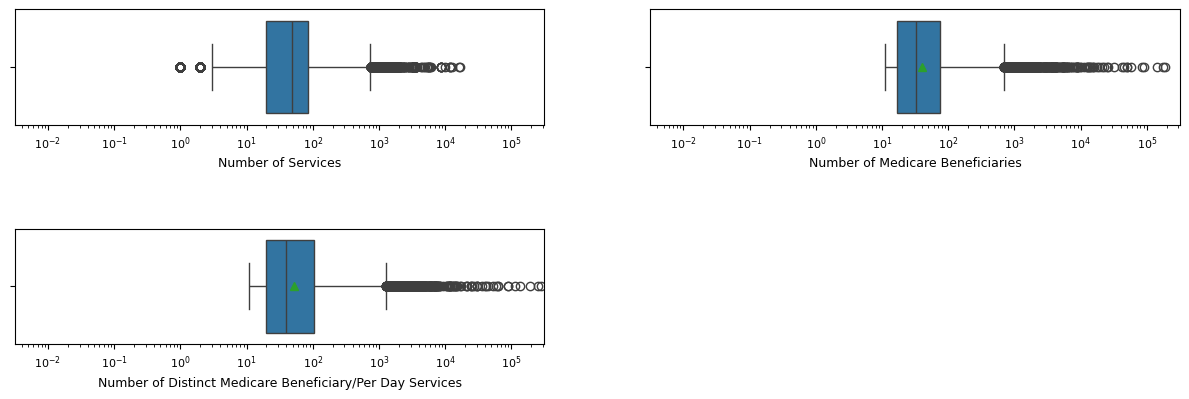

In [ ]:
countVariables = ["Number of Services", "Number of Medicare Beneficiaries", "Number of Distinct Medicare Beneficiary/Per Day Services"]
createBoxPlots(variables = countVariables)

##### Note: For the purpose of anomaly detection, the count variables are regarded here as continuous.

##### Create box plots of the continuous variables.

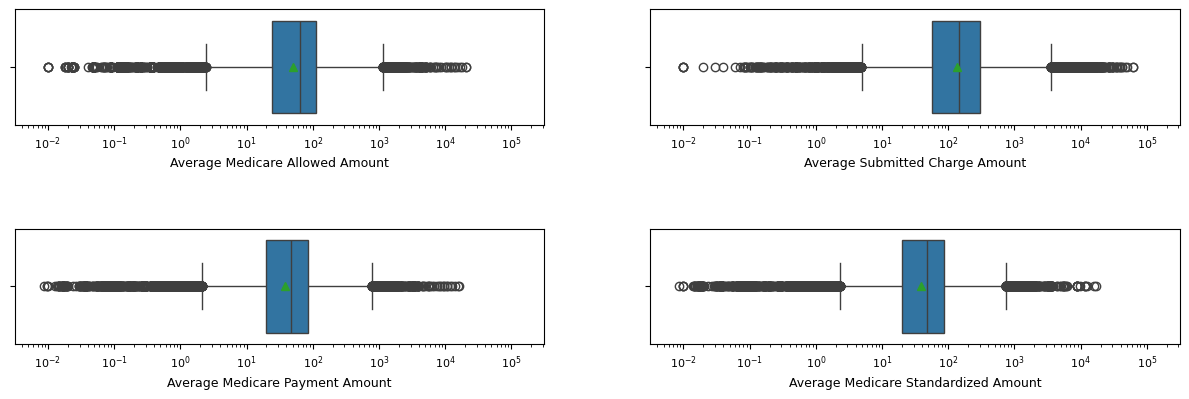

In [ ]:
continuousVariables = ["Average Medicare Allowed Amount", "Average Submitted Charge Amount", "Average Medicare Payment Amount",
                       "Average Medicare Standardized Amount"]
createBoxPlots(variables = continuousVariables)

$\hspace{1in}$

##### **Running Anomaly Detection Algorithms**

##### List the algorithms to be run.

In [ ]:
algorithms = [("ABOD", ABOD()),
              ("ALAD", ALAD()),
              ("CBLOF", CBLOF(clustering_estimator = KMeans(n_init = 1, random_state = 1),
                              random_state = 1)),
              ("CD", CD()),
              ("COPOD", COPOD()),
              ("DeepSVDD", DeepSVDD(verbose = 0, random_state = 1)),
              ("DIF", DIF(random_state = 1)),
              ("ECOD", ECOD()),
              ("FeatureBagging", FeatureBagging(random_state = 1)),
              ("GMM", GMM(n_components = 2, random_state = 1)),
              ("HBOS", HBOS(n_bins = "auto")),
              ("IForest", IForest(random_state = 1)),
              ("INNE", INNE(random_state = 1)),
              ("KNN", KNN()),
              ("LODA", LODA(n_bins = "auto")),
              ("LOF", LOF()),
              ("LUNAR", LUNAR()),
              ("MCD", MCD(random_state = 1)),
              ("PCA", PCA(random_state = 1)),
              ("QMCD", QMCD()),
              ("Sampling", Sampling(random_state = 1))]

##### Note: The `AnoGAN`, `COF`, `KDE`, `KPCA`, `LMDD`, `LOCI`, `LSCP`, `OCSVM`, `RGraph`, `ROD`, `SO_GAAL`, `SOD`, and `SOS` algorithms of the `pyod` package are excluded here since the algorithms take too long to run or the runtime environment crashes in the execution of the algorithms.

##### Run each algorithm on the dataset and determine the prediction for each row.

In [ ]:
startTimeAll = time.time()

categoricalVariables = dataset.select_dtypes(include = object).columns.tolist()
colTransformer = ColumnTransformer(transformers = [("categorical", OneHotEncoder(), categoricalVariables)],
                                   remainder = RobustScaler())
transformedDataset = colTransformer.fit_transform(dataset).toarray()

for algorithmName, algorithm in algorithms:

    startTimeAlgorithm = time.time()
    print("\n Running %s ..." % algorithmName, end = " ")

    if algorithmName == "DeepSVDD":

       with contextlib.redirect_stdout(io.StringIO()):
           algorithm.fit(transformedDataset)

    else:
       algorithm.fit(transformedDataset)

    dataset[algorithmName.lower() + " prediction"] = algorithm.labels_

    executionTimeAlgorithm = time.time() - startTimeAlgorithm

    if executionTimeAlgorithm < 60:
       print("Completed in %.2f seconds." % executionTimeAlgorithm)
    else:
       print("Completed in %.2f minutes." % (executionTimeAlgorithm/60))

executionTimeAll = time.time() - startTimeAll

if executionTimeAll < 60:
   print("\n Overall Execution Time = %.2f seconds" % executionTimeAll)
else:
   print("\n Overall Execution Time = %.2f minutes" % (executionTimeAll/60))


 Running ABOD ... Completed in 2.13 minutes.

 Running ALAD ... Completed in 2.29 minutes.

 Running CBLOF ... Completed in 3.67 seconds.

 Running CD ... Completed in 3.42 minutes.

 Running COPOD ... Completed in 2.70 seconds.

 Running DeepSVDD ... Completed in 8.74 minutes.

 Running DIF ... Completed in 6.96 minutes.

 Running ECOD ... Completed in 3.18 seconds.

 Running FeatureBagging ... Completed in 13.19 minutes.

 Running GMM ... Completed in 5.51 seconds.

 Running HBOS ... Completed in 3.60 minutes.

 Running IForest ... Completed in 9.09 seconds.

 Running INNE ... Completed in 16.95 seconds.

 Running KNN ... Completed in 1.55 minutes.

 Running LODA ... Completed in 1.16 minutes.

 Running LOF ... Completed in 1.55 minutes.

 Running LUNAR ... Completed in 32.37 minutes.

 Running MCD ... Completed in 1.27 minutes.

 Running PCA ... Completed in 2.46 seconds.

 Running QMCD ... Completed in 9.93 minutes.

 Running Sampling ... Completed in 0.21 seconds.

 Overall Execu

##### Note: Experiments can also be performed by running each algorithm on a dataset consisting only of the numeric variables, which could either be scaled or unscaled.

$\hspace{1in}$

##### **Results**

##### Get the total number for each record of the number of algorithms with predictions equal to 1. Sort the dataset in descending order of that number.

In [ ]:
algorithmNames = [name for name, _ in algorithms]
columnsToSum = [name.lower() + " prediction" for name in algorithmNames]
dataset["count of predictions = 1"] = dataset[columnsToSum].sum(axis = 1)
dataset.sort_values(by = "count of predictions = 1", ascending = False, inplace = True)
dataset.head()

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,abod prediction,alad prediction,cblof prediction,cd prediction,copod prediction,deepsvdd prediction,dif prediction,ecod prediction,featurebagging prediction,gmm prediction,hbos prediction,iforest prediction,inne prediction,knn prediction,loda prediction,lof prediction,lunar prediction,mcd prediction,pca prediction,qmcd prediction,sampling prediction,count of predictions = 1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9104319,M,O,CO,F,N,764,668,1074,977.49,3250.00,764.99,763.93,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21
3467689,M,O,KY,F,N,330,1924,2922,393.41,900.01,302.60,330.36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21
3507324,M,O,ID,O,N,25,44341,44965,25.05,25.74,24.55,25.08,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21
8458739,M,O,AZ,O,N,42,3313,10625,55.38,110.00,41.49,41.97,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21
121904,M,O,NJ,F,N,2124,11,11,3033.91,26523.40,2234.50,2123.67,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21


##### Display the distribution of the variable `count of predictions = 1`.

In [ ]:
counts = dataset["count of predictions = 1"].value_counts()
proportions = 100*dataset["count of predictions = 1"].value_counts(normalize = True)
predictionsEqualOne = pd.concat([counts, proportions], axis = 1, keys = ['count', 'proportion (%)'])
predictionsEqualOne.insert(loc = 0, column = "count of predictions = 1", value = predictionsEqualOne.index)
predictionsEqualOne.sort_values(by = "count of predictions = 1", ascending = False, inplace = True, ignore_index = True)
total = pd.DataFrame({"count of predictions = 1": ["total"], "count": [counts.sum()], "proportion (%)": [proportions.sum()]})
predictionsEqualOne = pd.concat([predictionsEqualOne, total], ignore_index = True)

def make_bold(val):

    return "font-weight: bold"

totalIndex = len(predictionsEqualOne) - 1
predictionsEqualOne = predictionsEqualOne.style.applymap(make_bold, subset = (slice(totalIndex, totalIndex, 1), "count of predictions = 1"))
predictionsEqualOne = predictionsEqualOne.format(formatter = '{:.2f}', subset = ["proportion (%)"])
predictionsEqualOne

,count of predictions = 1,count,proportion (%)
0,21,16,0.02
1,20,43,0.04
2,19,119,0.12
3,18,254,0.25
4,17,341,0.34
5,16,390,0.39
6,15,488,0.49
7,14,617,0.62
8,13,758,0.76
9,12,675,0.68


##### Reduce and visualize the dataset in 2D using *t-SNE*. Highlight the records that are predicted as anomalies by all the anomaly detection algorithms that were run.


 Execution Time = 31.29 minutes 



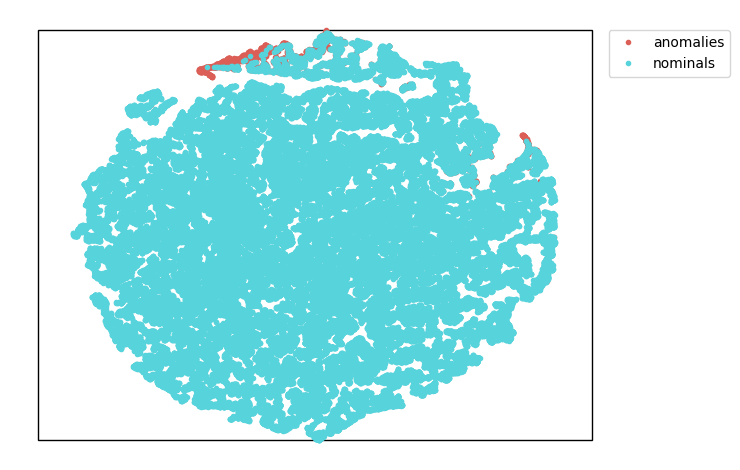

In [ ]:
startTime = time.time()

datasetToReduce = dataset[categoricalVariables + countVariables + continuousVariables].copy()
m = len(dataset[dataset["count of predictions = 1"] == 8])
n = len(dataset) - m
hue = [1]*m + [0]*n
geo = hyp.plot(datasetToReduce, fmt = ".", hue = hue, legend = ["anomalies", "nominals"], reduce = "TSNE", ndims = 2)
plt.legend(bbox_to_anchor = (0.97, 0.97))

executionTime = time.time() - startTime

if executionTime < 60:
   print("\n Execution Time = %.2f seconds \n" % executionTime)
else:
   print("\n Execution Time = %.2f minutes \n" % (executionTime/60))

plt.show()

##### Display a randomly selected record that is predicted to be an anomaly by all the anomaly detection algorithms that were run.

In [ ]:
selectedRecord = dataset[dataset["count of predictions = 1"] == len(algorithms)].sample(1)
selectedRecord

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,abod prediction,alad prediction,cblof prediction,cd prediction,copod prediction,deepsvdd prediction,dif prediction,ecod prediction,featurebagging prediction,gmm prediction,hbos prediction,iforest prediction,inne prediction,knn prediction,loda prediction,lof prediction,lunar prediction,mcd prediction,pca prediction,qmcd prediction,sampling prediction,count of predictions = 1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3467689,M,O,KY,F,N,330,1924,2922,393.41,900.01,302.60,330.36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21


##### Show the group in the Cartesian product of the categorical variables to which the selected anomaly belongs.

In [ ]:
subdataset = cartesianProduct.copy()

for variable in categoricalVariables:

    value = selectedRecord[variable].values[0]
    subdataset = subdataset[subdataset[variable] == value].copy()

subdataset

,Gender of the Provider,Entity Type of the Provider,State Code of the Provider,Place of Service,HCPCS Drug Indicator,count,proportion (%)
436,M,O,KY,F,N,4,0.00


##### Show the locations in the box plots of the values of the numeric features of the selected anomaly.

In [ ]:
createBoxPlots(variables = countVariables, showSelectedRecord = selectedRecord.index[0])

In [ ]:
createBoxPlots(variables = continuousVariables, showSelectedRecord = selectedRecord.index[0])

##### Highlight in the 2D-visualization the records that are predicted as anomalies by only one anomaly detection algorithm.

In [ ]:
startTime = time.time()

m = len(dataset[dataset["count of predictions = 1"] == 1])
n = len(dataset) - m
hue = [1]*m + [0]*n
geo = hyp.plot(datasetToReduce, fmt = ".", hue = hue, legend = ["anomalies", "nominals"], reduce = "TSNE", ndims = 2)
plt.legend(bbox_to_anchor = (0.97, 0.97))

executionTime = time.time() - startTime

if executionTime < 60:
   print("\n Execution Time = %.2f seconds \n" % executionTime)
else:
   print("\n Execution Time = %.2f minutes \n" % (executionTime/60))

plt.show()

##### Display a randomly selected record that is predicted to be an anomaly by only one anomaly detection algorithm.

In [ ]:
selectedRecord = dataset[dataset["count of predictions = 1"] == 1].sample(1)
selectedRecord

##### Show the group in the Cartesian product of the categorical variables to which the selected anomaly belongs.

In [ ]:
subdataset = cartesianProduct.copy()

for variable in categoricalVariables:

    value = selectedRecord[variable].values[0]
    subdataset = subdataset[subdataset[variable] == value].copy()

subdataset

##### Show the locations in the box plots of the values of the numeric features of the selected anomaly.

In [ ]:
createBoxPlots(variables = countVariables, showSelectedRecord = selectedRecord.index[0])

In [ ]:
createBoxPlots(variables = continuousVariables, showSelectedRecord = selectedRecord.index[0])